# **Procesamiento de Imágenes Médicas - Tomografía Computarizada (TAC)**

**Objetivo:** Comprender el procesamiento de imágenes médicas, específicamente de tomografías computarizadas (TAC). Los estudiantes aprenderán cómo leer archivos DICOM, interpretar unidades Hounsfield, preprocesar datos 3D y generar visualizaciones tridimensionales que son fundamentales en el diagnóstico médico moderno.

**Librerías utilizadas:**
*   `pydicom`: Para leer archivos DICOM (Digital Imaging and Communications in Medicine), el estándar en imagenología médica [1].
*   `NumPy`: Para operaciones numéricas en arreglos 3D.
*   `SciPy`: Especialmente `scipy.ndimage.zoom` para re-muestrear imágenes 3D.
*   `scikit-image`: Para segmentación y análisis 3D con el algoritmo marching cubes.
*   `Matplotlib` y `mpl_toolkits.mplot3d`: Para visualizaciones 2D y 3D.


In [2]:
# --- Instalación de la librería DICOM ---
!pip install pydicom

# --- Importación de librerías necesarias ---
import numpy as np
import pandas as pd
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import glob
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

  Using cached pydicom-3.0.1-py3-none-any.whl.metadata (9.4 kB)
Using cached pydicom-3.0.1-py3-none-any.whl (2.4 MB)


***

### **1. Introducción a DICOM y las Unidades Hounsfield**

**¿Qué es DICOM?**
DICOM (Digital Imaging and Communications in Medicine) es el estándar internacional para almacenar y transmitir imágenes médicas. Un archivo DICOM no es solo una imagen, sino que contiene información clínica crítica: datos del paciente, metadatos de la captura, parámetros de adquisición, y la imagen en sí.

**¿Qué son las Unidades Hounsfield (HU)?**
En una tomografía CT, el valor de cada píxel no es una simple intensidad de luz, sino una medida de la capacidad de absorción de rayos X del tejido en esa ubicación. Las Unidades Hounsfield (HU) ofrecen una escala estandarizada:
*   **-1024 HU:** Aire (completamente radiolúcido).
*   **0 HU:** Agua (referencia).
*   **+40 a +50 HU:** Tejido blando (músculo, órganos).
*   **+500 a +1000 HU:** Hueso (muy radiopaco).
*   **+3000 HU:** Metal.

Esta escala permite a los radiologos identificar y diferenciar tejidos de manera consistente.

- Descargar el archivo que contiene los archivos TAC (https://short.upm.es/3u5s7) y subirlo a Colab.
- Y descomprimelo con:
```python
!unzip ct_scans.zip
```

In [3]:
# --- Configuración del directorio de trabajo ---
# (Asumiendo que los archivos DICOM están en una carpeta local o descargados de internet)
input_folder = './ct_scans/'
patients = glob.glob(os.path.join(input_folder, '*.dcm'))
patients.sort()

print(f"Se encontraron {len(patients)} archivos DICOM.")
print(f"Primeros 5 archivos: {patients[:5]}")

Se encontraron 114 archivos DICOM.
Primeros 5 archivos: ['./ct_scans/1-001.dcm', './ct_scans/1-002.dcm', './ct_scans/1-003.dcm', './ct_scans/1-004.dcm', './ct_scans/1-005.dcm']


### **2. Lectura de Archivos DICOM**

Un TAC consiste de múltiples "slices" (cortes) transversales. Cada slice es un archivo DICOM separado. El objetivo es leer todos los slices, ordenarlos por posición anatómica (de cabeza a pies), y construir una imagen 3D [1].


In [4]:
def load_scan(files):
    """
    Carga una serie de archivos DICOM y los ordena por posición física.
    
    Parámetros:
    -----------
    files : list
        Lista de rutas a archivos DICOM.
    
    Retorna:
    --------
    slices : list
        Lista de objetos DicomDataset ordenados por posición.
    """
    # Leer todos los archivos DICOM
    slices = [dicom.dcmread(f) for f in files]
    
    # Ordenar por la coordenada Z (profundidad) de la posición del paciente
    # ImagePositionPatient[2] es la coordenada Z
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    
    # Calcular el espesor del slice (la distancia entre dos slices consecutivos)
    try:
        slice_thickness = np.abs(
            slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2]
        )
    except:
        # Alternativa si no está disponible ImagePositionPatient
        slice_thickness = np.abs(
            slices[0].SliceLocation - slices[1].SliceLocation
        )
    
    # Asignar el espesor a cada slice para cálculos posteriores
    for s in slices:
        s.SliceThickness = slice_thickness
    
    return slices

def get_pixels_hu(slices):
    """
    Convierte los valores de píxeles de los slices DICOM a Unidades Hounsfield (HU).
    
    Parámetros:
    -----------
    slices : list
        Lista de objetos DicomDataset.
    
    Retorna:
    --------
    image : np.ndarray
        Imagen 3D con valores en Unidades Hounsfield (HU).
    """
    # Apilar los arrays de píxeles de todos los slices en una matriz 3D
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    
    # Establecer píxeles fuera del escaneo a 0
    # El valor -2000 típicamente representa píxeles vacíos o fuera del rango
    image[image == -2000] = 0
    
    # Convertir a Unidades Hounsfield (HU) usando la fórmula DICOM
    # HU = pixel_value * slope + intercept
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

# --- Cargar el primer paciente ---
first_patient = load_scan(patients)
first_patient_pixels = get_pixels_hu(first_patient)

print(f"Forma (dimensiones) del volumen 3D: {first_patient_pixels.shape}")
print(f"(Numero de slices, Alto, Ancho) = {first_patient_pixels.shape}")

Forma (dimensiones) del volumen 3D: (114, 512, 512)
(Numero de slices, Alto, Ancho) = (114, 512, 512)


### **3. Análisis del Histograma de Unidades Hounsfield**

El histograma de HU nos permite identificar la distribución de diferentes tejidos en el volumen. Esto es crucial para entender qué órganos y tejidos están presentes [1].


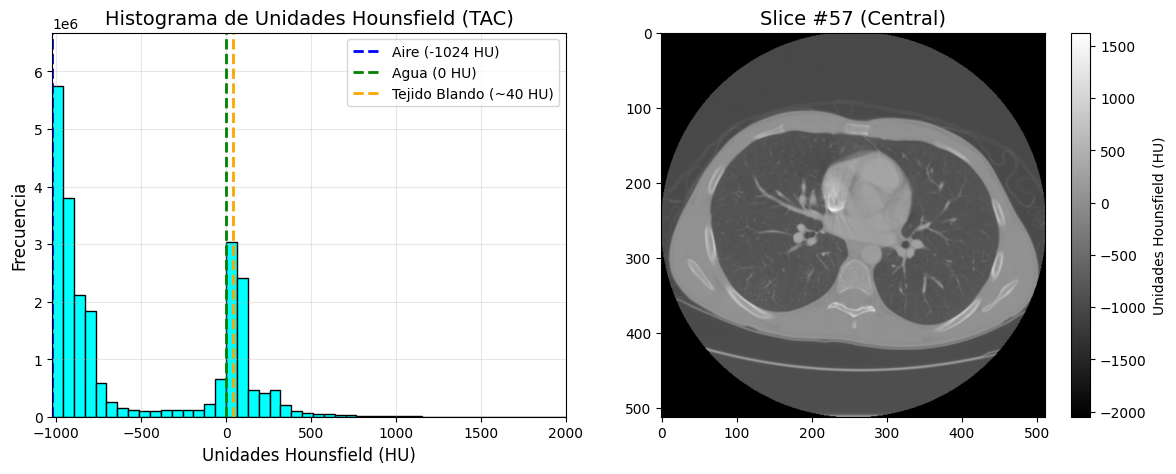

In [5]:
# --- Crear el histograma de HU ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(first_patient_pixels.flatten(), bins=80, color='cyan', edgecolor='black')
plt.xlabel('Unidades Hounsfield (HU)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Histograma de Unidades Hounsfield (TAC)', fontsize=14)
plt.grid(True, alpha=0.3)

# --- Interpretar el histograma ---
# Añadimos líneas de referencia para los diferentes tejidos
plt.axvline(x=-1024, color='blue', linestyle='--', linewidth=2, label='Aire (-1024 HU)')
plt.axvline(x=0, color='green', linestyle='--', linewidth=2, label='Agua (0 HU)')
plt.axvline(x=40, color='orange', linestyle='--', linewidth=2, label='Tejido Blando (~40 HU)')
plt.legend()
plt.xlim(-1024, 2000)

# --- Visualizar un slice individual ---
slice_idx = len(first_patient_pixels) // 2  # Slice del medio
plt.subplot(1, 2, 2)
plt.imshow(first_patient_pixels[slice_idx], cmap='gray')
plt.title(f'Slice #{slice_idx} (Central)', fontsize=14)
plt.colorbar(label='Unidades Hounsfield (HU)')

plt.tight_layout()
plt.show()

**Observación:** El histograma muestra picos claramente definidos. El pico más bajo (alrededor de -1000 HU) corresponde al aire fuera del cuerpo. Los picos intermedios corresponden a diferentes tejidos blandos, y los valores más altos corresponden a hueso.

### **4. Re-muestreo de Volúmenes 3D (Resampling)**

Las imágenes CT generalmente tienen un espaciado anisotrópico, lo que significa que la distancia entre slices (eje Z) puede ser diferente a la distancia entre píxeles dentro de un slice (ejes X e Y). El re-muestreo crea un volumen isotrópico (espaciado uniforme en todas direcciones), que es más conveniente para análisis posteriores.


In [6]:
def resample(image, scan, new_spacing=[1, 1, 1]):
    """
    Re-muestrea una imagen 3D a un espaciado uniforme.
    
    Parámetros:
    -----------
    image : np.ndarray
        Volumen 3D original.
    scan : list
        Lista de slices DICOM (necesarios para obtener el espaciado original).
    new_spacing : list
        Espaciado deseado en mm (por defecto, 1mm isotrópico).
    
    Retorna:
    --------
    image : np.ndarray
        Volumen re-muestreado.
    new_spacing : np.ndarray
        El espaciado real después del re-muestreo.
    """
    # Obtener el espaciado original
    # PixelSpacing es [espaciado en filas, espaciado en columnas]
    spacing = np.array([
        scan[0].SliceThickness, 
        scan[0].PixelSpacing[0], 
        scan[0].PixelSpacing[1]
    ], dtype=np.float32)
    
    # Calcular el factor de redimensionamiento
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing_actual = spacing / real_resize_factor
    
    # Aplicar el zoom (re-muestreo) usando interpolación de vecino más cercano
    image_resampled = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')
    
    return image_resampled, new_spacing_actual

# --- Aplicar re-muestreo ---
print("Procesando...")
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1, 1, 1])

print(f"Forma antes del re-muestreo: {first_patient_pixels.shape}")
print(f"Forma después del re-muestreo: {pix_resampled.shape}")
print(f"Espaciado nuevo: {spacing} mm")

Procesando...
Forma antes del re-muestreo: (114, 512, 512)
Forma después del re-muestreo: (285, 340, 340)
Espaciado nuevo: [1.         0.99999928 0.99999928] mm


### **5. Segmentación y Reconstrucción 3D**

Un volumen CT contiene aire, tejido blando y hueso. Para visualizar mejor el hueso (por ejemplo, la estructura ósea del tórax), aplicamos un **umbral** (threshold) para segmentar solo los píxeles con valores HU correspondientes a hueso.

Luego, utilizamos el algoritmo **Marching Cubes** para convertir esta segmentación 3D binaria en una malla poligonal 3D, que puede ser visualizada interactivamente.


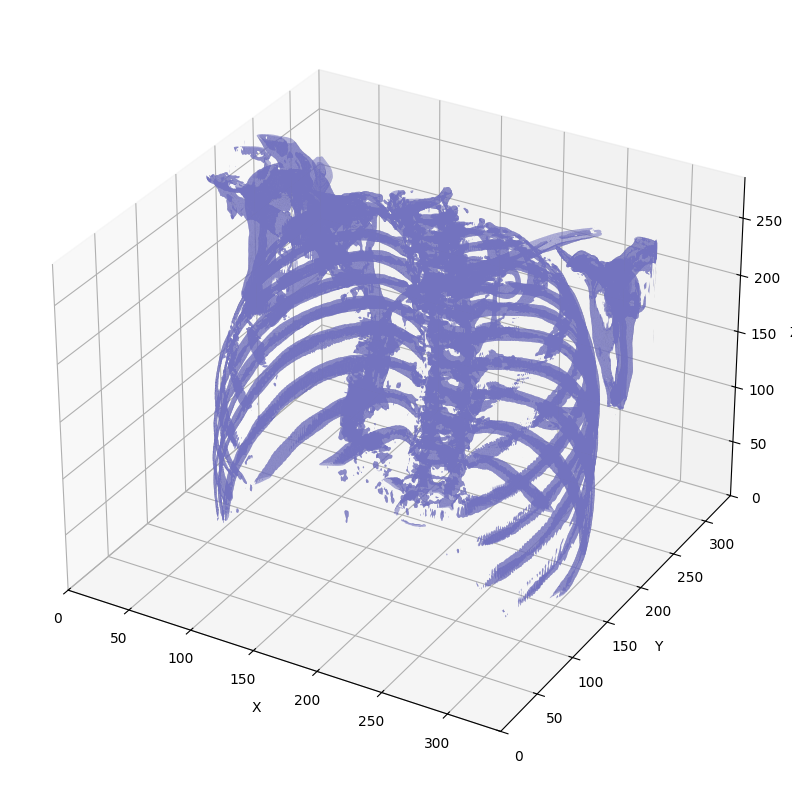

In [7]:
def plot_3d(image, threshold=-300):
    """
    Visualiza una segmentación 3D usando el algoritmo Marching Cubes.
    
    Parámetros:
    -----------
    image : np.ndarray
        Volumen 3D (típicamente tras aplicar un threshold).
    threshold : int
        Valor de umbral de Hounsfield para la segmentación.
        Los píxeles con valores > threshold serán incluidos.
    """
    # Transponer para cambiar la orientación: así la cabeza queda hacia arriba
    # p[0] = izquierda/derecha, p[1] = superior/inferior, p[2] = profundidad
    p = image.transpose(2, 1, 0)
    
    # Ejecutar el algoritmo Marching Cubes
    # Retorna los vértices y caras del polígono 3D
    verts, faces, normals, values = measure.marching_cubes(p, threshold)
    
    # Crear la figura 3D
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Generar la malla poligonal a partir de los vértices y caras
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    
    # Establecer color de la malla
    face_color = [0.45, 0.45, 0.75]  # Azul grisáceo
    mesh.set_facecolor(face_color)
    
    # Añadir la malla a la figura
    ax.add_collection3d(mesh)
    
    # Establecer los límites de los ejes
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    
    # Etiquetas de los ejes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

# --- Visualizar la estructura ósea ---
# Un threshold de 400 HU captura principalmente hueso
plot_3d(pix_resampled, threshold=400)

**Nota:** La visualización 3D permite rotar, hacer zoom e inspeccionar la estructura anatómica desde cualquier ángulo. Esto es similar a lo que hace un radiólogo al revisar un TAC en la clínica.

### **6. Ejercicios Propuestos**

**Ejercicio 1: Exploración de Diferentes Umbrales**
1.  El código original usa un threshold de 400 HU para visualizar hueso.
2.  Prueba diferentes valores: 0 (solo tejido blando), 100, 200, 300, 500.
3.  Para cada umbral, llama a `plot_3d(pix_resampled, threshold=tu_valor)`.
4.  Anota lo que observas: ¿Qué estructuras son visibles con cada umbral? ¿Cuál crees que es el más útil clínicamente?

**Ejercicio 2: Análisis Estadístico de Regiones**
1.  Define dos regiones de interés (ROI) dentro del volumen seleccionando rangos de índices, por ejemplo:
    ```python
    roi_1 = pix_resampled[50:100, 100:200, 100:200]
    roi_2 = pix_resampled[150:200, 200:300, 100:200]
    ```
2.  Para cada ROI, calcula: media, desviación estándar, mínimo y máximo de HU.
3.  ¿Qué tejidos crees que están representados en cada ROI basándote en los valores HU?

**Ejercicio 3: Visualización de Slices Axiales y Sagitales**
1.  Hasta ahora hemos visualizado slices axiales (plano transversal, el más común en TAC).
2.  Usando re-cortes del volumen 3D, visualiza:
    - Slice axial: `pix_resampled[i, :, :]`
    - Slice sagital (plano lateral): `pix_resampled[:, :, j]`
    - Slice coronal (plano frontal): `pix_resampled[:, j, :]`
3.  Crea una figura con 3 subplots mostrando estos tres planos simultáneamente.

**Ejercicio 4 (Avanzado): Segmentación Manual de Órganos**
1.  Selecciona un órgano de interés en la imagen (por ejemplo, el hígado, visible entre 20 y 60 HU promedio).
2.  Usando un rango de valores HU característicos de ese órgano, crea una máscara binaria:
    ```python
    organ_mask = (pix_resampled > 20) & (pix_resampled < 60)
    ```
3.  Aplica operaciones morfológicas (erosión y dilatación) de `skimage.morphology` para limpiar la máscara.
4.  Visualiza la segmentación en 3D usando `plot_3d(organ_mask.astype(int) * 255, threshold=128)`.
